# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo add K-fold
# Todo choose the best params and cnn architecture
# Todo add a pipeline to scale params
# Todo implement augmentation?

In [2]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')
args.n_splits = 5
args.n_jobs = 3
args.val_fraction = 0.1
args.epochs = 200
args.model_name = 'model.hdf5'

args.X = args.raw_train.iloc[:, 1:].copy()
args.y = args.raw_train['label'].copy()
args.x = args.raw_test.copy()

args.run_baseline_cnn = False
args.run_kfold_cnn = False

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [4]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


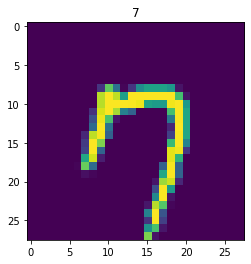

In [7]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
plt.title(title)
imgplot = plt.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

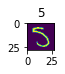

In [8]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
fig, ax = plt.subplots()
fig.set_size_inches(0.5, 0.5)
ax.set_title(title)
imgplot = ax.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

## 2. Training

In [9]:
X = args.X.to_numpy().reshape(args.X.shape[0], 28, 28, 1)
y = pd.get_dummies(args.y, prefix='label').to_numpy()
x = args.x.to_numpy().reshape(args.x.shape[0], 28, 28, 1)

In [10]:
def predict(X, y, x, build_classifier, parameters, splits=args.n_splits, n_jobs=args.n_jobs):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    classifier = build_classifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=n_jobs, cv=skf, verbose=5)
    gcv.fit(X, y)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    classifier = build_classifier(gcv.best_params_)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

In [11]:
def csv_predictions(predictions, filename):
    image_ids = np.arange(1, len(predictions) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)

In [12]:
from keras import layers 
from keras import models

def build_baseline_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    log.info(model.summary())
    return model

Using TensorFlow backend.


### 2.1 Baseline

In [13]:
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

if args.run_baseline_cnn:
    # val_loss
    # val_accuracy
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, mode='auto', verbose=1)
    model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor='val_accuracy', mode='auto', verbose=1)
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='auto')

    
    build_baseline_model().fit(X, y, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])
    # build_baseline_model().fit(X, y, epochs=args.epochs, batch_size=64, verbose=1)
    model.load_weights(args.model_name)
    predictions = model.predict(x)
    predictions = np.argmax(predictions, axis=1)
    csv_predictions(predictions, 'cnn_predictions.csv')

### 2.2 K-Fold

In [14]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [15]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

if args.run_kfold_cnn:
    keras_classifier = KerasClassifier(build_baseline_model, batch_size=64)
    gcv = GridSearchCV(keras_classifier,
                             param_grid={'epochs': [3, 4, 5, 10]},
                             cv=5,
                             scoring='neg_log_loss',
                             n_jobs=-1,
                             verbose=5)
    gcv.fit(X, y)

    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: ' + repr(gcv.best_score_))        
    log.info('Best std:' + repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    # validator.best_estimator_ returns sklearn-wrapped version of best model.
    # validator.best_estimator_.model returns the (unwrapped) keras model
    best_model = gcv.best_estimator_.model
    predictions = best_model.predict(x)
    predictions = np.argmax(predictions, axis=1)
    csv_predictions(predictions, 'cnn_predictions_kfold.csv')

### 2.3 Choosing the best cnn architecture

In [23]:
from keras import layers 
from keras import models

layer_candidates = [
    [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')],
    [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')],
]

default_layer_list = [
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')]

def build_model(layer_list=default_layer_list):
    model = models.Sequential(layer_list)
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    log.info('Build model:')
    log.info(model.summary())
    return model

In [25]:
from keras import layers 


keras_classifier = KerasClassifier(build_model, batch_size=64, layer_list=default_layer_list)
gcv = GridSearchCV(keras_classifier,
                         param_grid={'epochs': [3], 'layer_list': layer_candidates},
                         cv=5,
                         scoring='neg_log_loss',
                         n_jobs=-1,
                         verbose=5)
gcv.fit(X, y)

RuntimeError: Cannot clone object <keras.wrappers.scikit_learn.KerasClassifier object at 0x17b2fa2d0>, as the constructor either does not set or modifies parameter layer_list

In [ ]:
assert False

In [ ]:
args.X.shape
args.X.to_numpy().reshape(args.X.shape[0], 28, 28, 1)
pd.get_dummies(args.y, prefix='label').to_numpy()

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def svm_classifier_builder(params_dict=None):
    _params_dict = params_dict if params_dict else {}
    return SVC(**_params_dict, kernel='linear')

parameters = {'C': [0.01], 'gamma': [0.001]}

if args.run_svm:
    best_params, score, predictions = predict(args.X, args.y, args.x, svm_classifier_builder, parameters)
    csv_predictions(predictions, 'svm_predictions.csv')

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | No validation, 200 epochs  | 0.99157, 0.98857 |
| Baseline | Validation (20%), 45 epochs  | 0.98885 |
| Baseline | Validation (20%), 200 epochs, early stopping val_loss  | 0.98628 |
| Baseline | Validation (20%), 200 epochs, early stopping val_accuracy  | 0.98957 |
| Baseline | Validation (10%), 200 epochs, early stopping val_loss  | 0.98700 |
| Baseline | Validation (10%), 200 epochs, early stopping val_accuracy  | 0.98857 |
| K-Fold | Scoring neg_log_loss, cv=5  | 0.98200 |
| K-Fold | Scoring neg_log_loss, cv=12  | 0.98142 |